## Introduction

 NBSVM (Naive Bayes - Support Vector Machine) to create a strong baseline for the Toxic Comment Classification Challenge. Use logistic regression rather than SVM. 

In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [3]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')
subm = pd.read_csv('../input/sample_submission.csv')

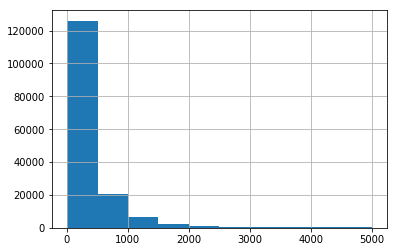

In [6]:
lens = train.comment_text.str.len()
#Using the Hist function to check on the various lengths of the comments
lens.hist()

We'll create a list of all the labels to predict, and we'll also create a 'none' label so we can see how many comments have no labels. We can then summarize the dataset.

In [9]:
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
#If a comment is non toxic we introduce a category called none and assign corresponding labels
train['none'] = 1-train[label_cols].max(axis=1)
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,none
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,1
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,1
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,1
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,1
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,1


There are a few empty comments that we need to get rid of, otherwise sklearn will complain.

In [11]:
#Filling out missing comments

COMMENT = 'comment_text'
train[COMMENT].fillna("nan", inplace=True)
test[COMMENT].fillna("nan", inplace=True)

## Building the model

*  create a *bag of words* representation
*  as a *term document matrix* while using ngrams

In [12]:
#Define Regex tokenize function to accomplish Tokenization task
import re, string
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s): return re_tok.sub(r' \1 ', s).split()

It turns out that using TF-IDF gives even better priors than the binarized features used in the paper. I don't think this has been mentioned in any paper before, but it improves leaderboard score from 0.59 to 0.55.

In [17]:
#Obtain TF-IDF vectors 
n = train.shape[0]
vec = TfidfVectorizer(ngram_range=(1,2), tokenizer=tokenize,
               min_df=3, max_df=0.9, strip_accents='unicode', use_idf=1,
               smooth_idf=1, sublinear_tf=1 )
trn_term_doc = vec.fit_transform(train[COMMENT])
test_term_doc = vec.transform(test[COMMENT])

In [25]:
#All features corresponding to the Tokenizer used here
len(vec.get_feature_names())

426005

This creates a *sparse matrix* with only a small number of non-zero elements (*stored elements* in the representation  below).

In [24]:
#Document Term Matrices
trn_term_doc, test_term_doc

(<159571x426005 sparse matrix of type '<class 'numpy.float64'>'
 	with 17775104 stored elements in Compressed Sparse Row format>,
 <153164x426005 sparse matrix of type '<class 'numpy.float64'>'
 	with 14765755 stored elements in Compressed Sparse Row format>)

In [27]:
#Basic Naive Bayes Equation

def pr(y_i, y):
    p = x[y==y_i].sum(0)
    return (p+1) / ((y==y_i).sum()+1)

In [28]:
x = trn_term_doc
test_x = test_term_doc

Fit a model for one dependent at a time:

In [29]:
def get_mdl(y):
    y = y.values
    r = np.log(pr(1,y) / pr(0,y))
    m = LogisticRegression(C=4, dual=True)
    x_nb = x.multiply(r)
    return m.fit(x_nb, y), r

In [30]:
preds = np.zeros((len(test), len(label_cols)))

for i, j in enumerate(label_cols):
    print('fit', j)
    m,r = get_mdl(train[j])
    preds[:,i] = m.predict_proba(test_x.multiply(r))[:,1]

fit toxic


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


fit severe_toxic


/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


fit obscene
fit threat
fit insult
fit identity_hate


And finally, create the submission file.

In [ ]:
submid = pd.DataFrame({'id': subm["id"]})
submission = pd.concat([submid, pd.DataFrame(preds, columns = label_cols)], axis=1)
submission.to_csv('submission.csv', index=False)

In [32]:
preds[0]

array([0.99998783, 0.106266  , 0.99998669, 0.00236916, 0.96257808,
       0.0949553 ])

In [36]:
test_labels = pd.read_csv('../input/test_labels.csv')
test.tail()

,id,comment_text
153159,fffcd0960ee309b5,". \n i totally agree, this stuff is nothing bu..."
153160,fffd7a9a6eb32c16,== Throw from out field to home plate. == \n\n...
153161,fffda9e8d6fafa9e,""" \n\n == Okinotorishima categories == \n\n I ..."
153162,fffe8f1340a79fc2,""" \n\n == """"One of the founding nations of the..."
153163,ffffce3fb183ee80,""" \n :::Stop already. Your bullshit is not wel..."
